## Imports

In [120]:
import matplotlib.pyplot as plt
import sqlite3
from collections import defaultdict
from statistics import mean
import json
import os

## Fetch Data Sources DB

In [121]:
def fetch_sessions(conn):
    """Fetch all sessions from the database."""
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM sessions')
    columns = [description[0] for description in cursor.description]
    sessions = [dict(zip(columns, row)) for row in cursor.fetchall()]
    return sessions

db_path = 'analytics.db'
if not os.path.exists(db_path):
    print(f"Database file {db_path} does not exist.")
else:
    conn = sqlite3.connect(db_path)
    sessions = fetch_sessions(conn)
    conn.close()
    print("Sessions fetched successfully.")

Database file analytics.db does not exist.


## Config Used

In [122]:
def fetch_config_used(config_path):
    """Fetch configuration used from the configuration file."""
    if os.path.exists(config_path):
        with open(config_path, 'r') as config_file:
            config_used = config_file.read()
        return config_used
    else:
        return "No configuration file found."

config_used_file = 'config_used.json'
config_used = fetch_config_used(config_used_file)
print("Configuration Used:")
print(config_used)

Configuration Used:
No configuration file found.


## Summary

In [123]:
def compute_summary_statistics(sessions):
    """Compute summary statistics from sessions."""
    all_sessions = sessions
    completed_sessions = [s for s in sessions if s['session_termination_reason'] == 'completed']
    timeout_sessions = [s for s in sessions if s['session_termination_reason'] == 'timeout']
    
    total_tokens = sum(s.get('session_tokens', 0) for s in sessions)
    total_cost = sum(s.get('session_cost', 0.0) for s in sessions)
    total_time = sum(s.get('duration', 0.0) for s in sessions)
    
    summary = {
        'Total Sessions': len(all_sessions),
        'Completed Sessions': len(completed_sessions),
        'Timeout Sessions': len(timeout_sessions),
        'Total Tokens Used': total_tokens,
        'Total Cost': total_cost,
        'Total Time (seconds)': total_time
    }
    
    if timeout_sessions:
        summary['Average Steps in Timeout Sessions'] = mean(s.get('navigation_steps', 0) for s in timeout_sessions)
        summary['Average Cost in Timeout Sessions'] = mean(s.get('session_cost', 0.0) for s in timeout_sessions)
        summary['Average Tokens in Timeout Sessions'] = mean(s.get('session_tokens', 0) for s in timeout_sessions)
    else:
        summary['Average Steps in Timeout Sessions'] = 0
        summary['Average Cost in Timeout Sessions'] = 0.0
        summary['Average Tokens in Timeout Sessions'] = 0
    
    if completed_sessions:
        summary['Average Time in Completed Sessions'] = mean(s.get('duration', 0.0) for s in completed_sessions)
        summary['Average Steps in Completed Sessions'] = mean(s.get('navigation_steps', 0) for s in completed_sessions)
        summary['Average Score in Completed Sessions'] = mean(s.get('session_score', 0.0) for s in completed_sessions)
        summary['Average Cost in Completed Sessions'] = mean(s.get('session_cost', 0.0) for s in completed_sessions)
        summary['Average Tokens in Completed Sessions'] = mean(s.get('session_tokens', 0) for s in completed_sessions)
        
        success_sessions = [s for s in completed_sessions if s.get('session_score', 0.0) == 1.0]
        summary['Success Ratio (All Sessions)'] = len(success_sessions) / len(all_sessions) if all_sessions else 0
        summary['Success Ratio (Completed Sessions)'] = len(success_sessions) / len(completed_sessions) if completed_sessions else 0
    else:
        summary['Average Time in Completed Sessions'] = 0.0
        summary['Average Steps in Completed Sessions'] = 0
        summary['Average Score in Completed Sessions'] = 0.0
        summary['Average Cost in Completed Sessions'] = 0.0
        summary['Average Tokens in Completed Sessions'] = 0
        summary['Success Ratio (All Sessions)'] = 0
        summary['Success Ratio (Completed Sessions)'] = 0
    
    return summary, completed_sessions, timeout_sessions

summary, completed_sessions, timeout_sessions = compute_summary_statistics(sessions)
print("Summary Statistics:")
for key, value in summary.items():
    print(f"{key}: {value}")

Summary Statistics:
Total Sessions: 501
Completed Sessions: 437
Timeout Sessions: 64
Total Tokens Used: 0
Total Cost: 0.0
Total Time (seconds): 26759.57545399666
Average Steps in Timeout Sessions: 4.8125
Average Cost in Timeout Sessions: 0.0
Average Tokens in Timeout Sessions: 0
Average Time in Completed Sessions: 43.61621231181671
Average Steps in Completed Sessions: 6.604118993135011
Average Score in Completed Sessions: 0.6484946060804184
Average Cost in Completed Sessions: 0.0
Average Tokens in Completed Sessions: 0
Success Ratio (All Sessions): 0.2694610778443114
Success Ratio (Completed Sessions): 0.30892448512585813


## Page Visit Statistics

In [124]:
def compute_page_visits(sessions):
    """Compute page visit statistics."""
    page_visits = defaultdict(lambda: {'All Visits': 0, 'Completed Visits': 0, 'Timeout Visits': 0})
    
    for session in sessions:
        for page in ['count_page_index', 'count_page_search_results', 'count_page_item_page', 'count_page_item_sub_page', 'count_page_done']:
            count = session.get(page, 0)
            page_name = page.replace('count_page_', '')
            page_visits[page_name]['All Visits'] += count
            if session['session_termination_reason'] == 'completed':
                page_visits[page_name]['Completed Visits'] += count
            elif session['session_termination_reason'] == 'timeout':
                page_visits[page_name]['Timeout Visits'] += count
    
    return page_visits

page_visits = compute_page_visits(sessions)
print("Page Visits:")
for page, counts in page_visits.items():
    print(f"Page: {page}")
    for count_key, count_value in counts.items():
        print(f"  {count_key}: {count_value}")

Page Visits:
Page: index
  All Visits: 1221
  Completed Visits: 1042
  Timeout Visits: 179
Page: search_results
  All Visits: 679
  Completed Visits: 609
  Timeout Visits: 70
Page: item_page
  All Visits: 823
  Completed Visits: 774
  Timeout Visits: 49
Page: item_sub_page
  All Visits: 34
  Completed Visits: 24
  Timeout Visits: 10
Page: done
  All Visits: 437
  Completed Visits: 437
  Timeout Visits: 0


## Bucketed Results wrt Session Score

In [125]:
def compute_bucketed_results(sessions):
    """Compute bucketed results based on session_score."""
    buckets = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),
               (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0),(1.0,1.1)]
    bucketed_results = []
    
    for lower, upper in buckets:
        bucket_sessions = [s for s in sessions if s.get('session_score') is not None and lower <= float(s['session_score']) < upper]
        if bucket_sessions:
            avg_time = mean(s.get('duration', 0.0) for s in bucket_sessions)
            avg_steps = mean(s.get('navigation_steps', 0) for s in bucket_sessions)
            avg_score = mean(float(s.get('session_score', 0.0)) for s in bucket_sessions)
            avg_cost = mean(s.get('session_cost', 0.0) for s in bucket_sessions)
            avg_tokens = mean(s.get('session_tokens', 0) for s in bucket_sessions)
            
            bucketed_results.append({
                'Bucket Range': f"{lower} - {upper}",
                'Number of Sessions': len(bucket_sessions),
                'Average Time (seconds)': avg_time,
                'Average Steps': avg_steps,
                'Average Score': avg_score,
                'Average Cost (cents)': avg_cost,
                'Average Tokens': avg_tokens
            })
    
    return bucketed_results

bucketed_results = compute_bucketed_results(sessions)
print("Bucketed Results:")
for bucket in bucketed_results:
    print(f"Bucket Range: {bucket['Bucket Range']}")
    print(f"  Number of Sessions: {bucket['Number of Sessions']}")
    print(f"  Average Time (seconds): {bucket['Average Time (seconds)']}")
    print(f"  Average Steps: {bucket['Average Steps']}")
    print(f"  Average Score: {bucket['Average Score']}")
    print(f"  Average Score: {bucket['Average Score']}")
    print(f"  Average Cost (cents): {bucket['Average Cost (cents)']}")
    print(f"  Average Tokens: {bucket['Average Tokens']}")
    print()


Bucketed Results:
Bucket Range: 0 - 0.1
  Number of Sessions: 104
  Average Time (seconds): 93.32392592842763
  Average Steps: 5.586538461538462
  Average Score: 0.010032051282051275
  Average Score: 0.010032051282051275
  Average Cost (cents): 0.0
  Average Tokens: 0

Bucket Range: 0.1 - 0.2
  Number of Sessions: 10
  Average Time (seconds): 53.415528893470764
  Average Steps: 7.7
  Average Score: 0.11583333333333333
  Average Score: 0.11583333333333333
  Average Cost (cents): 0.0
  Average Tokens: 0

Bucket Range: 0.2 - 0.3
  Number of Sessions: 15
  Average Time (seconds): 45.54345582326253
  Average Steps: 6.066666666666666
  Average Score: 0.24333333333333335
  Average Score: 0.24333333333333335
  Average Cost (cents): 0.0
  Average Tokens: 0

Bucket Range: 0.3 - 0.4
  Number of Sessions: 29
  Average Time (seconds): 40.092903244084326
  Average Steps: 6.275862068965517
  Average Score: 0.33218390804597697
  Average Score: 0.33218390804597697
  Average Cost (cents): 0.0
  Average 

# Graphs

## Basic Bucketing - session_score

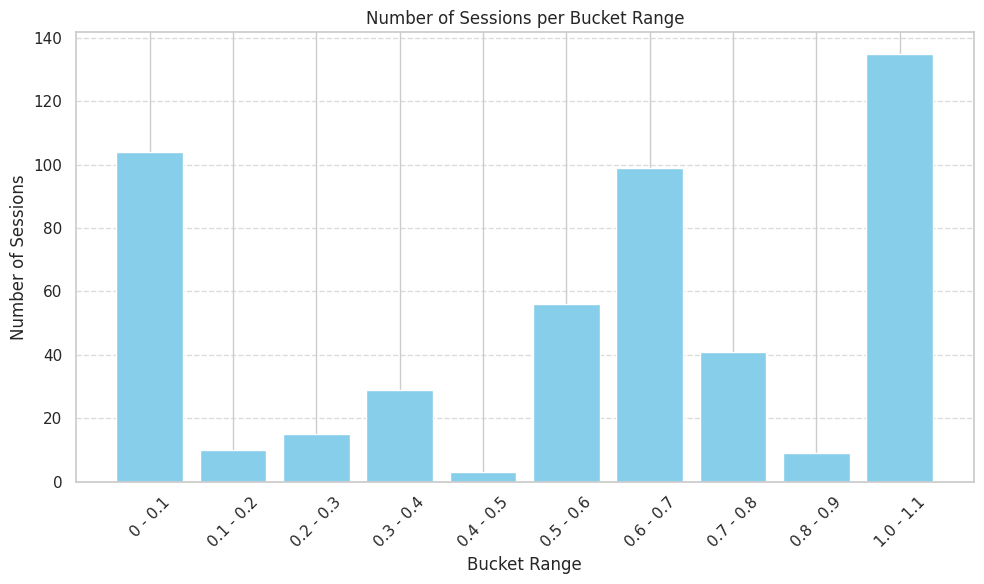

In [126]:
# PROMPT : generate code to visualize the bucketing from 0 to 1 with divisions of 0.01 just like done above. The data we are interested in count v/s bucket its in

def plot_bucketed_results(bucketed_results):
    """Plot the bucketed results as a bar chart."""
    bucket_ranges = [bucket['Bucket Range'] for bucket in bucketed_results]
    session_counts = [bucket['Number of Sessions'] for bucket in bucketed_results]

    plt.figure(figsize=(10, 6))
    plt.bar(bucket_ranges, session_counts, color='skyblue')
    plt.xlabel('Bucket Range')
    plt.ylabel('Number of Sessions')
    plt.title('Number of Sessions per Bucket Range')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_bucketed_results(bucketed_results)


## Basis Bucketing - r_option

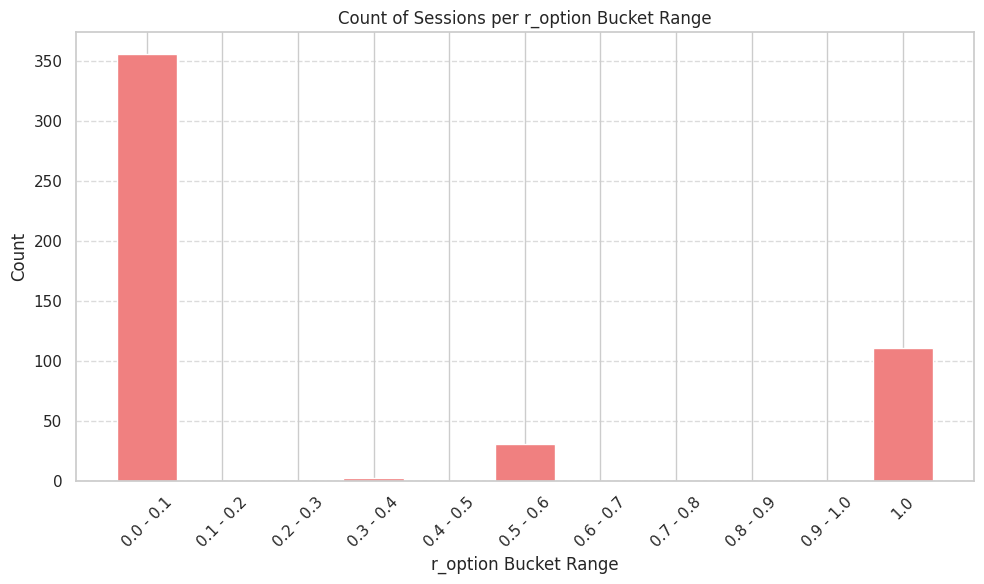

In [127]:
# PROMPT : generate a graph for the r_option bucketed from 0 to 1 as 0.1 increments v/s the count, i need the 1 values as well


def plot_r_option_bucketed_results(sessions):
    """Plot the r_option bucketed results as a bar chart."""
    buckets = [(i/10, (i+1)/10) for i in range(10)]
    bucket_counts = {f"{lower} - {upper}": 0 for lower, upper in buckets}
    bucket_counts["1.0"] = 0  # Add a bucket for the value 1.0
    
    for session in sessions:
        r_option = session.get('r_option', 0.0)
        if r_option == 1.0:
            bucket_counts["1.0"] += 1
        else:
            for lower, upper in buckets:
                if lower <= r_option < upper:
                    bucket_counts[f"{lower} - {upper}"] += 1
                    break
    
    bucket_ranges = list(bucket_counts.keys())
    counts = list(bucket_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(bucket_ranges, counts, color='lightcoral')
    plt.xlabel('r_option Bucket Range')
    plt.ylabel('Count')
    plt.title('Count of Sessions per r_option Bucket Range')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_r_option_bucketed_results(sessions)



## r_att bucketing wrt session score bucketing

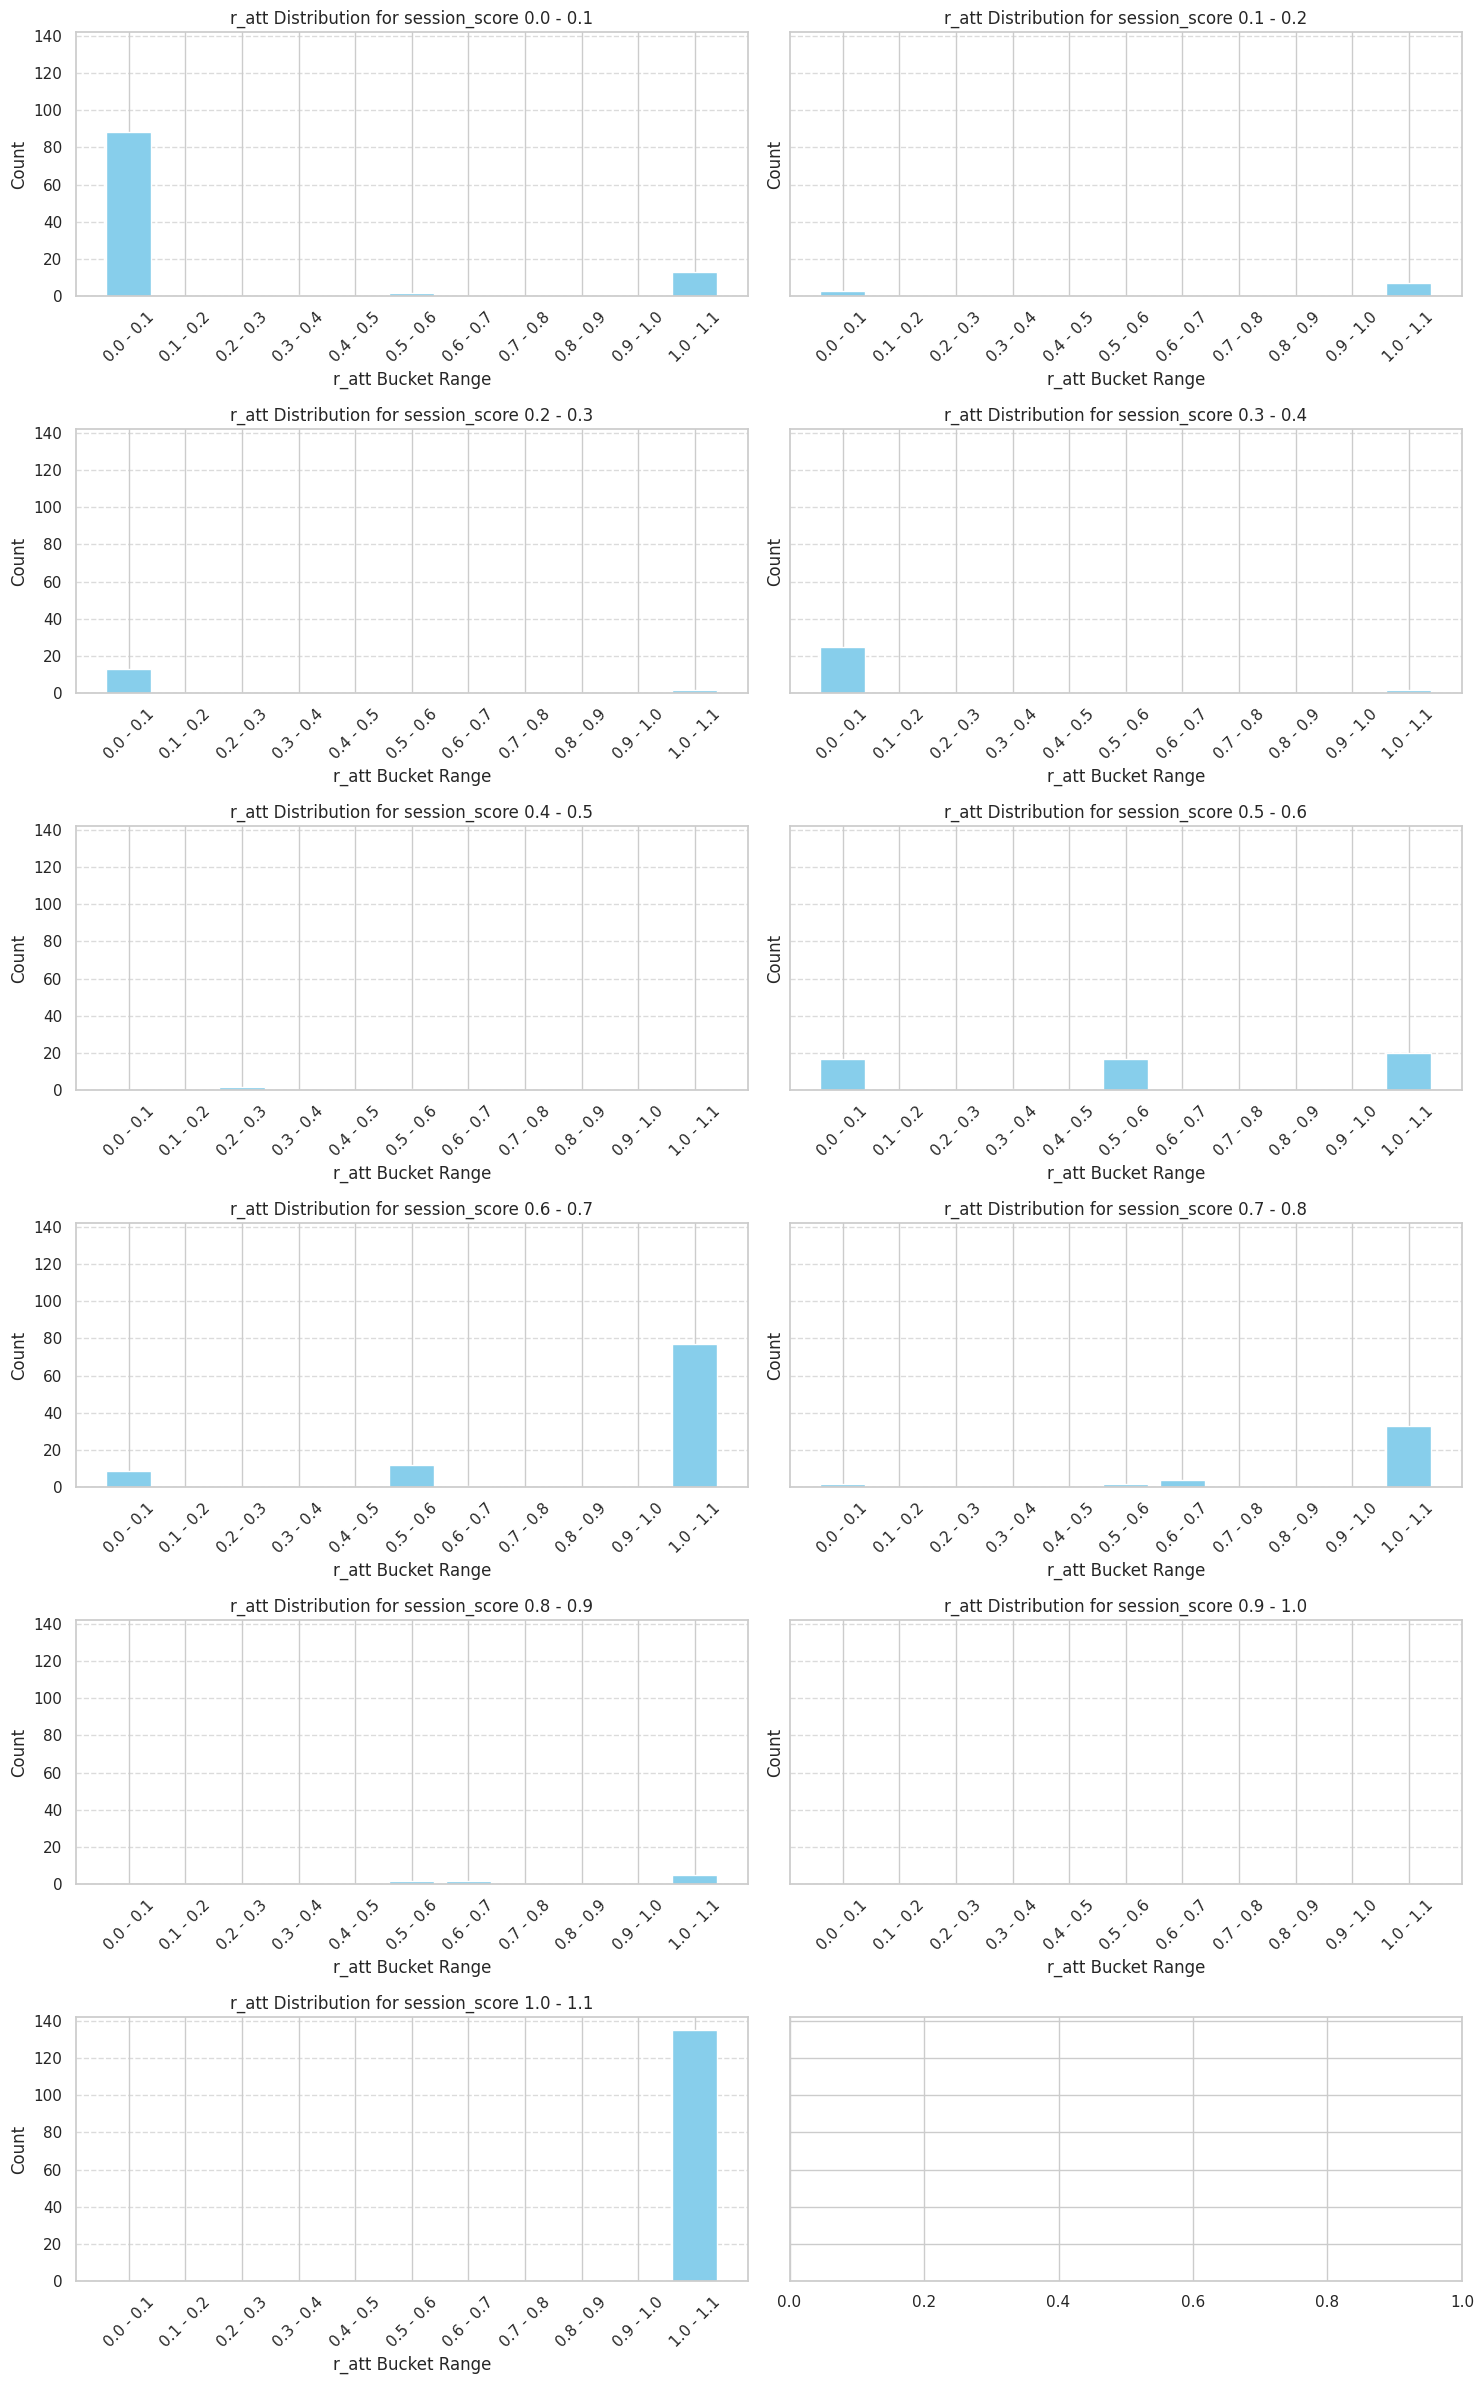

In [128]:
# PROMPT : generate graph between count and r_attr ( bucketed ) for each bucket based on session_score. So for each bucket their own r_attr distribution graph

def plot_r_att_distribution_per_score_bucket(sessions):
    """Plot r_att distribution for each session_score bucket."""
    score_buckets = [(i/10, (i+1)/10) for i in range(10)]
    score_buckets.append((1.0, 1.1))  # Corrected to include the range 1.0 to 1.1
    r_att_buckets = [(i/10, (i+1)/10) for i in range(10)]
    r_att_buckets.append((1.0, 1.1))  # Corrected to include the range 1.0 to 1.1

    # Initialize a dictionary to hold r_att counts for each score bucket
    score_bucket_r_att_counts = {f"{lower} - {upper}": {f"{r_lower} - {r_upper}": 0 for r_lower, r_upper in r_att_buckets} for lower, upper in score_buckets}

    for session in sessions:
        session_score = session.get('session_score', 0.0)
        r_att = session.get('r_att', 0.0)
        
        # Determine the score bucket
        score_bucket = None
        if 1.0 <= session_score <= 1.1:
            score_bucket = "1.0 - 1.1"
        else:
            for lower, upper in score_buckets:
                if lower <= session_score < upper:
                    score_bucket = f"{lower} - {upper}"
                    break

        # Determine the r_att bucket
        r_att_bucket = None
        if 1.0 <= r_att <= 1.1:
            r_att_bucket = "1.0 - 1.1"
        else:
            for r_lower, r_upper in r_att_buckets:
                if r_lower <= r_att < r_upper:
                    r_att_bucket = f"{r_lower} - {r_upper}"
                    break

        # Increment the count for the corresponding bucket
        if score_bucket and r_att_bucket:
            score_bucket_r_att_counts[score_bucket][r_att_bucket] += 1

    # Plotting
    fig, axes = plt.subplots(6, 2, figsize=(15, 24), sharey=True)
    axes = axes.flatten()

    for idx, (score_bucket, r_att_counts) in enumerate(score_bucket_r_att_counts.items()):
        if idx >= len(axes):
            break  # Prevent IndexError if there are more buckets than subplots

        bucket_ranges = list(r_att_counts.keys())
        counts = list(r_att_counts.values())

        axes[idx].bar(bucket_ranges, counts, color='skyblue')
        axes[idx].set_xlabel('r_att Bucket Range')
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'r_att Distribution for session_score {score_bucket}')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_r_att_distribution_per_score_bucket(sessions)


## r_option bucketing wrt session score bucketing

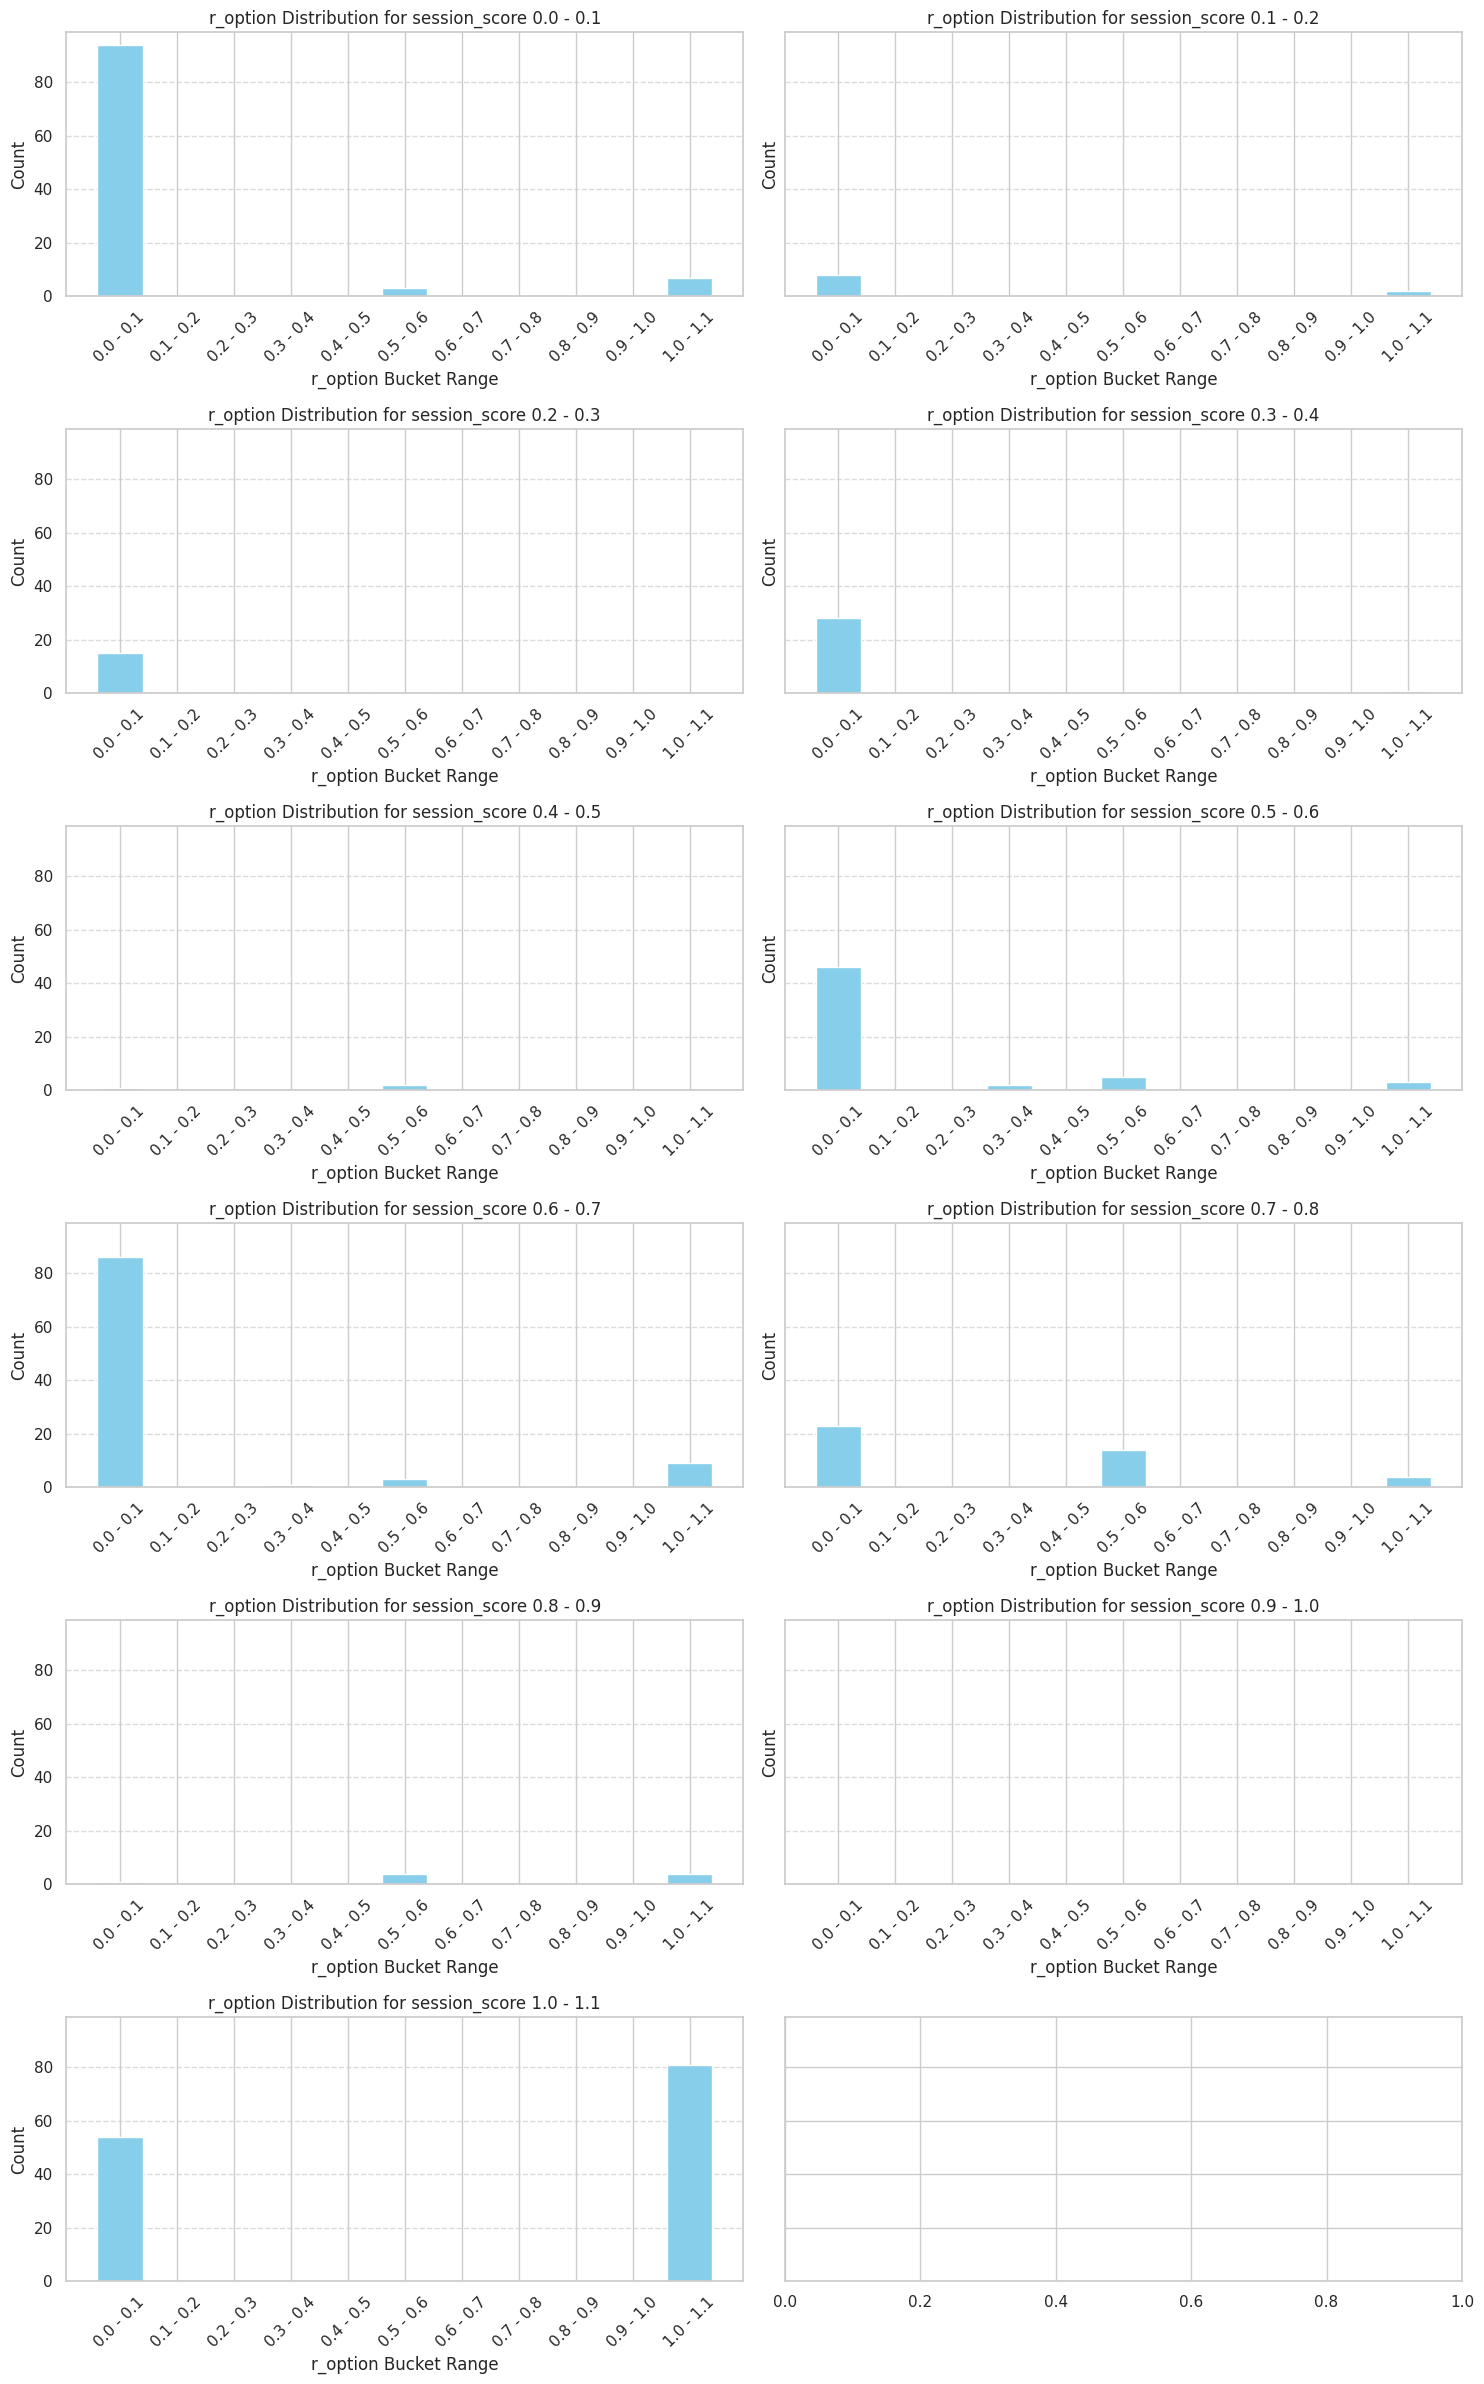

In [129]:
def plot_r_option_distribution_per_score_bucket(sessions):
    # Define the score buckets (referencing the previous cell)
    score_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Define the r_option buckets
    r_option_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Initialize a dictionary to hold counts for each score bucket and r_option bucket
    score_bucket_r_option_counts = {f"{lower:.1f} - {upper:.1f}": {f"{r_lower:.1f} - {r_upper:.1f}": 0 for r_lower, r_upper in r_option_buckets} for lower, upper in score_buckets}

    for session in sessions:
        session_score = session['session_score']
        r_option = session['r_option']

        # Determine the score bucket
        score_bucket = None
        for lower, upper in score_buckets:
            if lower <= session_score < upper:
                score_bucket = f"{lower:.1f} - {upper:.1f}"
                break

        # Determine the r_option bucket
        r_option_bucket = None
        for r_lower, r_upper in r_option_buckets:
            if r_lower <= r_option < r_upper:
                r_option_bucket = f"{r_lower:.1f} - {r_upper:.1f}"
                break

        # Increment the count for the corresponding bucket
        if score_bucket and r_option_bucket:
            score_bucket_r_option_counts[score_bucket][r_option_bucket] += 1

    # Plotting
    fig, axes = plt.subplots(6, 2, figsize=(15, 24), sharey=True)
    axes = axes.flatten()

    for idx, (score_bucket, r_option_counts) in enumerate(score_bucket_r_option_counts.items()):
        if idx >= len(axes):
            break  # Prevent IndexError if there are more buckets than subplots

        bucket_ranges = list(r_option_counts.keys())
        counts = list(r_option_counts.values())

        axes[idx].bar(bucket_ranges, counts, color='skyblue')
        axes[idx].set_xlabel('r_option Bucket Range')
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'r_option Distribution for session_score {score_bucket}')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_r_option_distribution_per_score_bucket(sessions)


## r_type bucketing wrt session score bucketing

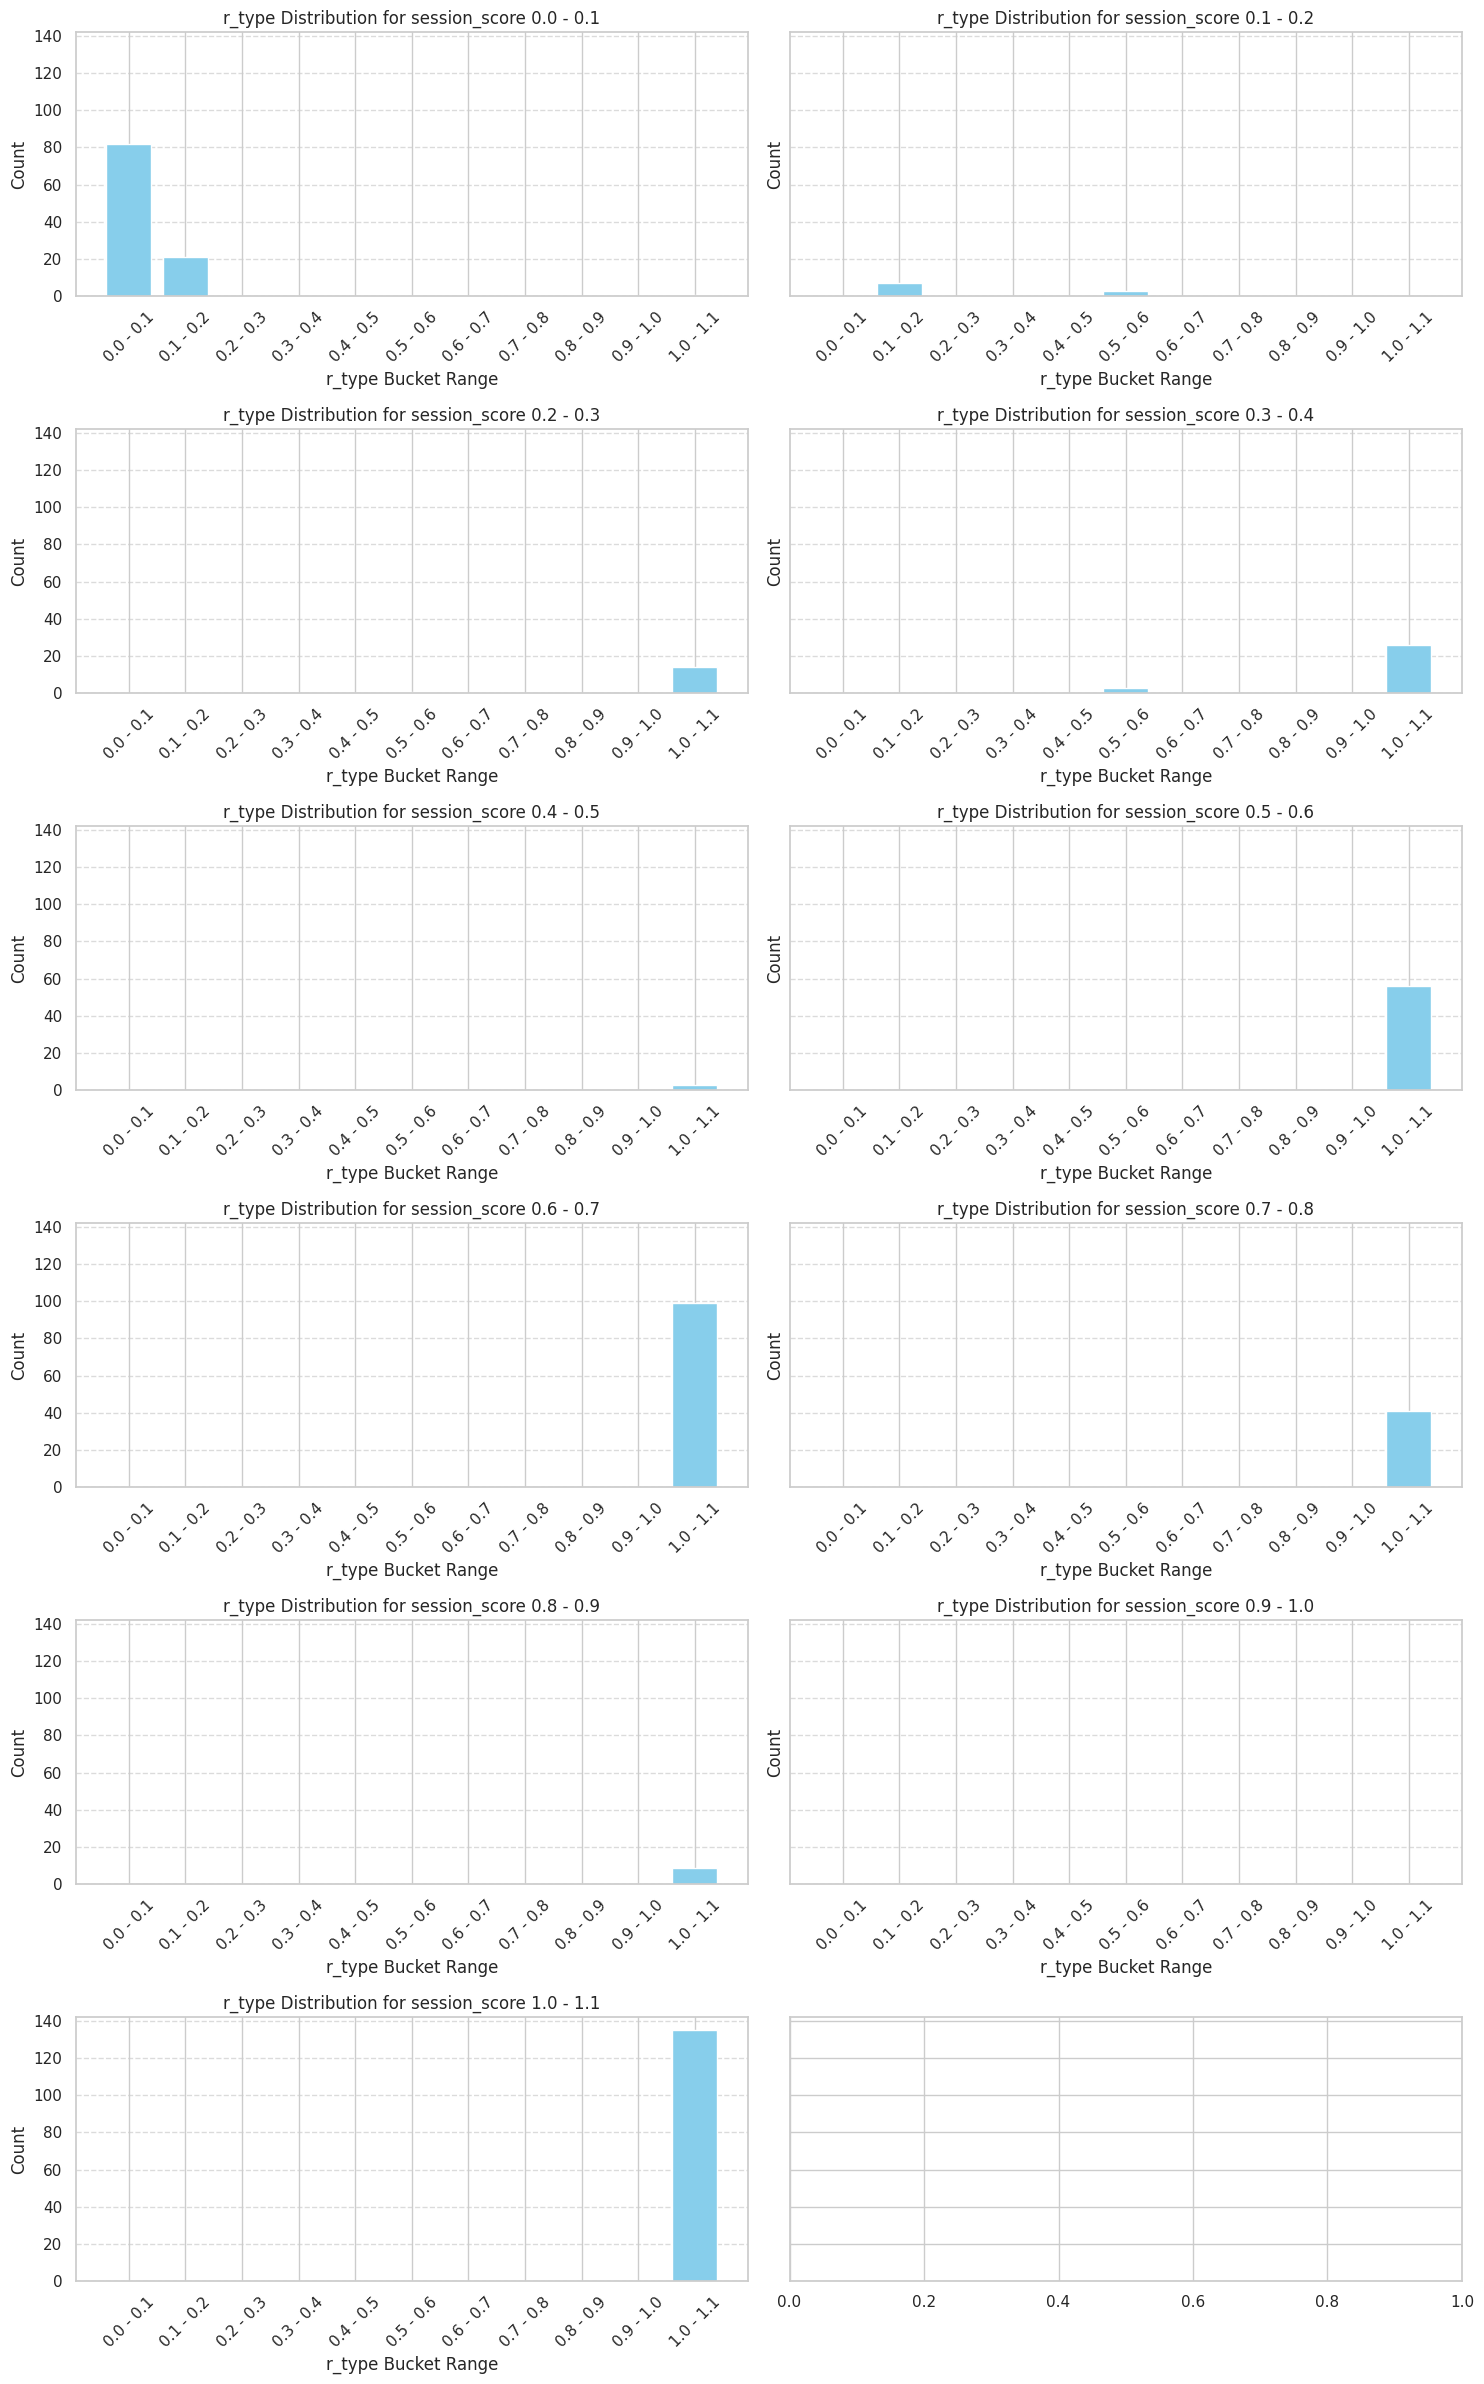

In [130]:
def plot_r_type_distribution_per_score_bucket(sessions):
    # Define the score buckets (referencing the previous cell)
    score_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Define the r_type buckets
    r_type_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Initialize a dictionary to hold counts for each score bucket and r_type bucket
    score_bucket_r_type_counts = {f"{lower:.1f} - {upper:.1f}": {f"{r_lower:.1f} - {r_upper:.1f}": 0 for r_lower, r_upper in r_type_buckets} for lower, upper in score_buckets}

    for session in sessions:
        session_score = session['session_score']
        r_type = session['r_type']

        # Determine the score bucket
        score_bucket = None
        for lower, upper in score_buckets:
            if lower <= session_score < upper:
                score_bucket = f"{lower:.1f} - {upper:.1f}"
                break

        # Determine the r_type bucket
        r_type_bucket = None
        for r_lower, r_upper in r_type_buckets:
            if r_lower <= r_type < r_upper:
                r_type_bucket = f"{r_lower:.1f} - {r_upper:.1f}"
                break

        # Increment the count for the corresponding bucket
        if score_bucket and r_type_bucket:
            score_bucket_r_type_counts[score_bucket][r_type_bucket] += 1

    # Plotting
    fig, axes = plt.subplots(6, 2, figsize=(15, 24), sharey=True)
    axes = axes.flatten()

    for idx, (score_bucket, r_type_counts) in enumerate(score_bucket_r_type_counts.items()):
        if idx >= len(axes):
            break  # Prevent IndexError if there are more buckets than subplots

        bucket_ranges = list(r_type_counts.keys())
        counts = list(r_type_counts.values())

        axes[idx].bar(bucket_ranges, counts, color='skyblue')
        axes[idx].set_xlabel('r_type Bucket Range')
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'r_type Distribution for session_score {score_bucket}')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_r_type_distribution_per_score_bucket(sessions)


## title_score bucketing wrt session score bucketing

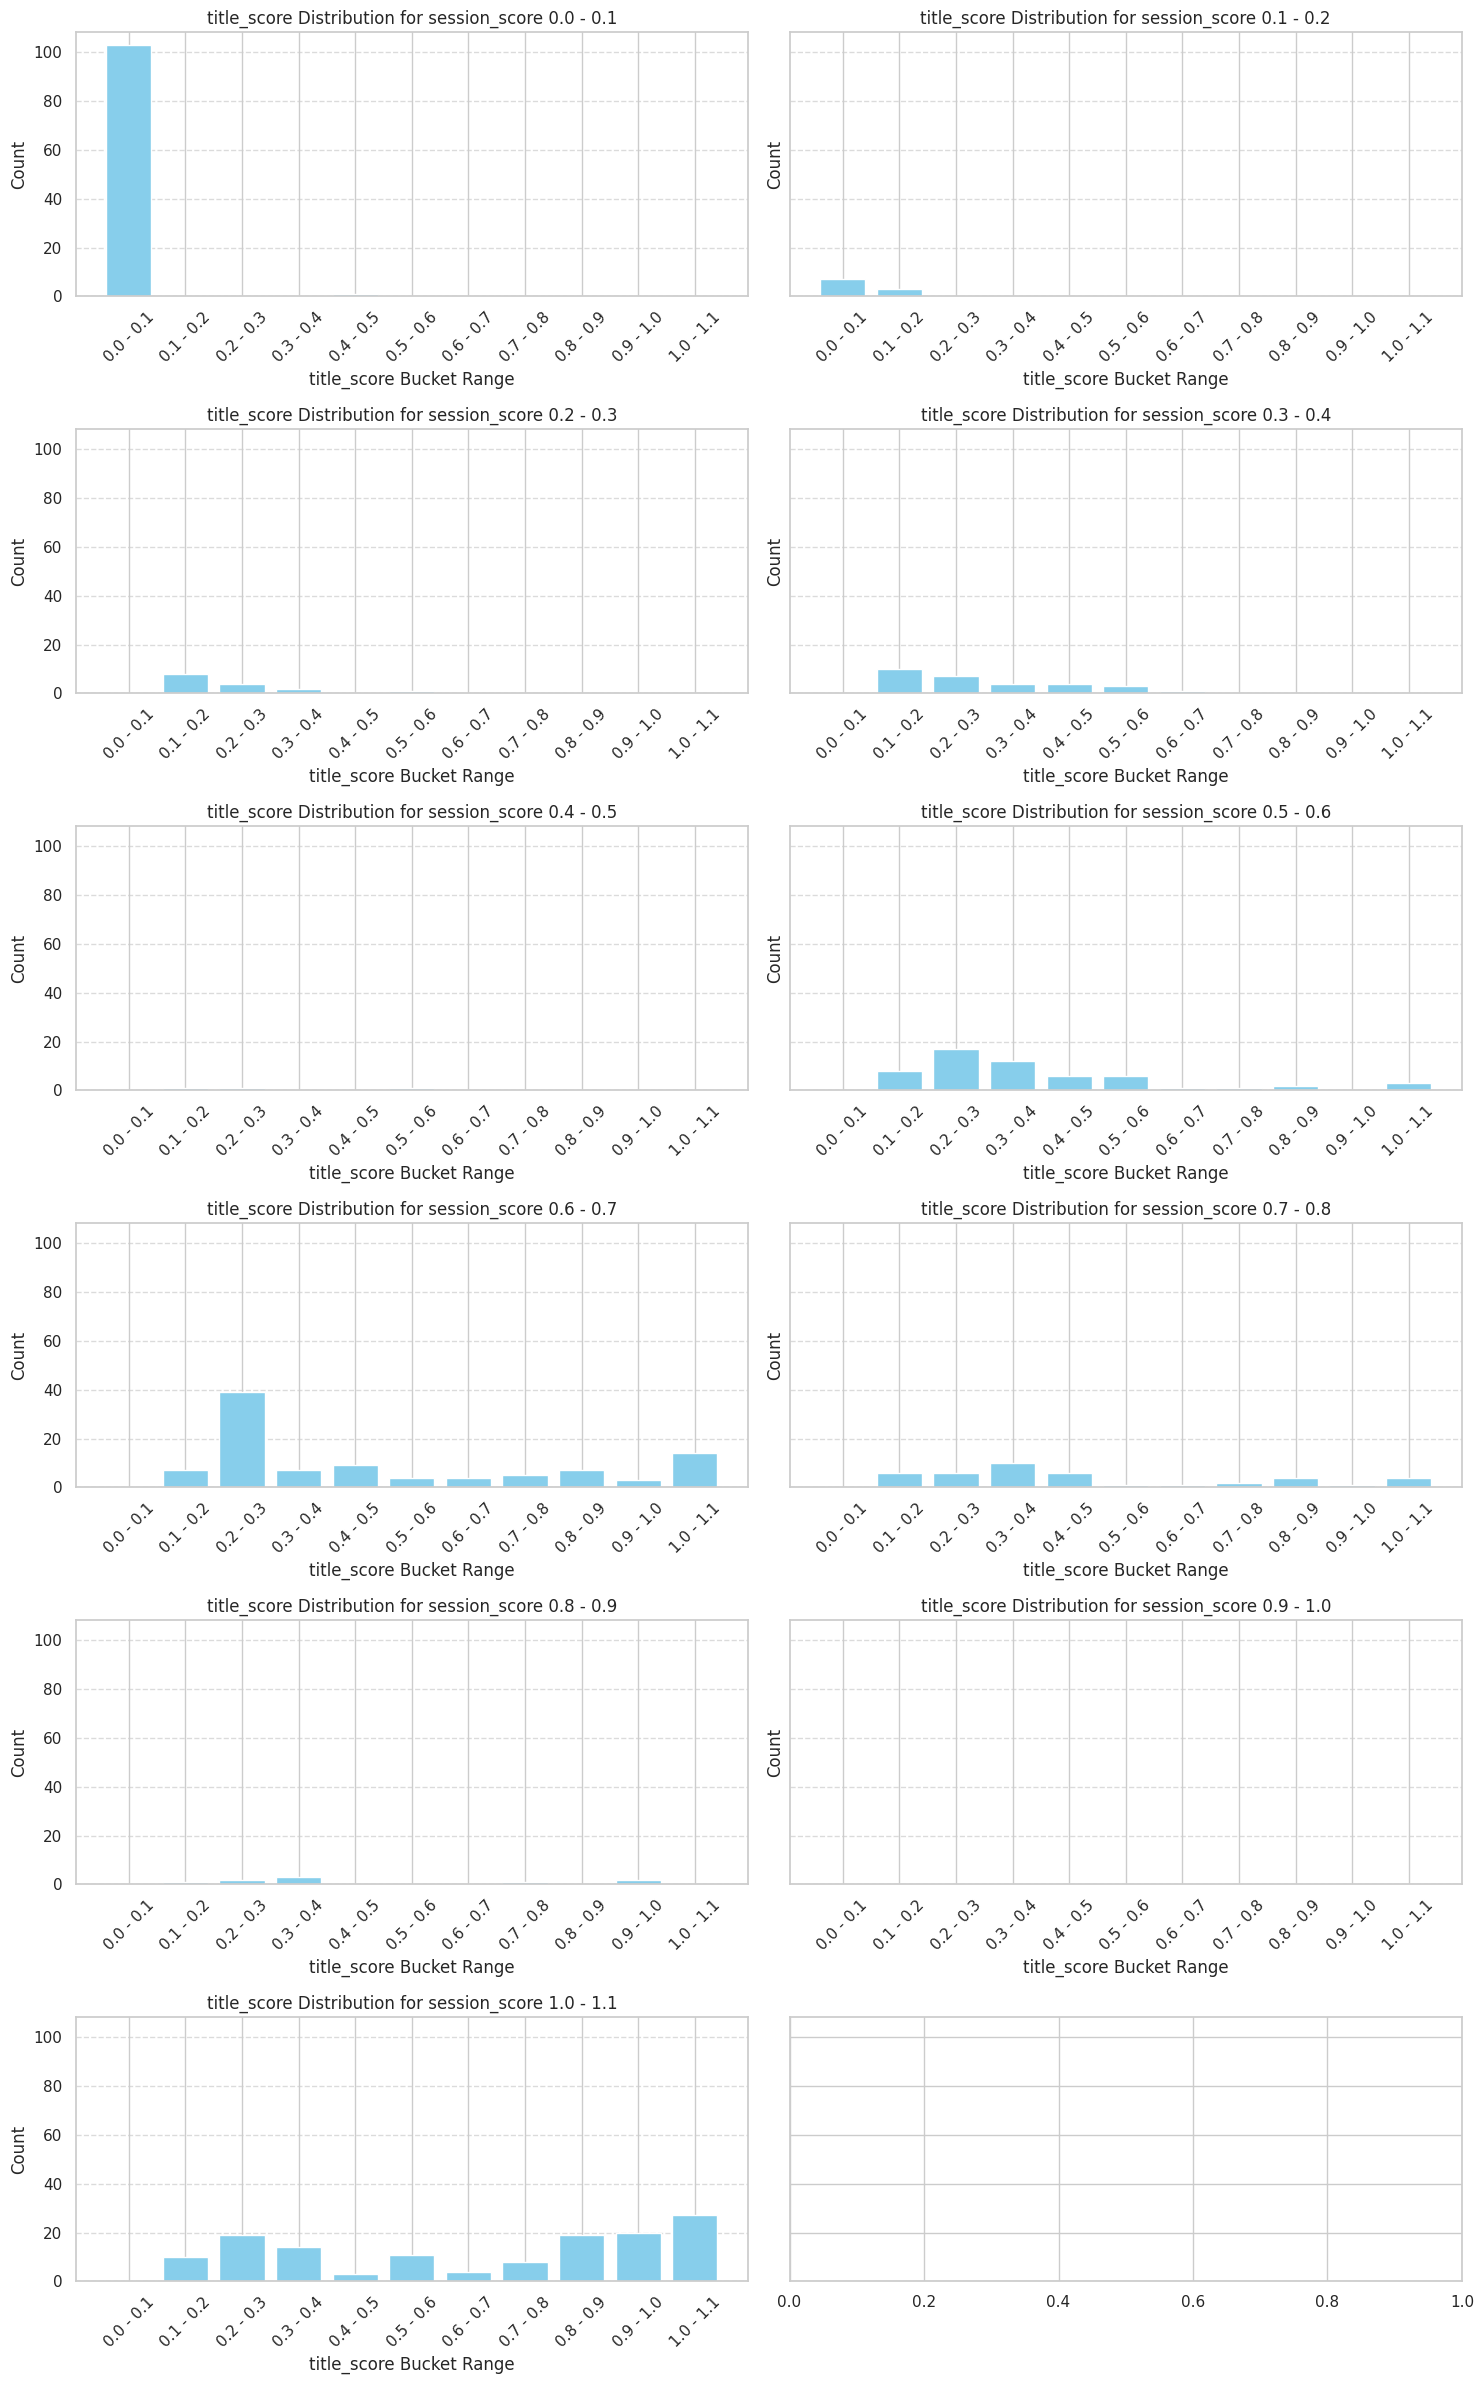

In [131]:
def plot_title_score_distribution_per_score_bucket(sessions):
    # Define the score buckets (referencing the previous cell)
    score_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Define the title_score buckets
    title_score_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Initialize a dictionary to hold counts for each score bucket and title_score bucket
    score_bucket_title_score_counts = {f"{lower:.1f} - {upper:.1f}": {f"{r_lower:.1f} - {r_upper:.1f}": 0 for r_lower, r_upper in title_score_buckets} for lower, upper in score_buckets}

    for session in sessions:
        session_score = session['session_score']
        title_score = session['title_score']

        # Determine the score bucket
        score_bucket = None
        for lower, upper in score_buckets:
            if lower <= session_score < upper:
                score_bucket = f"{lower:.1f} - {upper:.1f}"
                break

        # Determine the title_score bucket
        title_score_bucket = None
        for r_lower, r_upper in title_score_buckets:
            if r_lower <= title_score < r_upper:
                title_score_bucket = f"{r_lower:.1f} - {r_upper:.1f}"
                break

        # Increment the count for the corresponding bucket
        if score_bucket and title_score_bucket:
            score_bucket_title_score_counts[score_bucket][title_score_bucket] += 1

    # Plotting
    fig, axes = plt.subplots(6, 2, figsize=(15, 24), sharey=True)
    axes = axes.flatten()

    for idx, (score_bucket, title_score_counts) in enumerate(score_bucket_title_score_counts.items()):
        if idx >= len(axes):
            break  # Prevent IndexError if there are more buckets than subplots

        bucket_ranges = list(title_score_counts.keys())
        counts = list(title_score_counts.values())

        axes[idx].bar(bucket_ranges, counts, color='skyblue')
        axes[idx].set_xlabel('title_score Bucket Range')
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'title_score Distribution for session_score {score_bucket}')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_title_score_distribution_per_score_bucket(sessions)


## r_price bucketing wrt session score bucketing

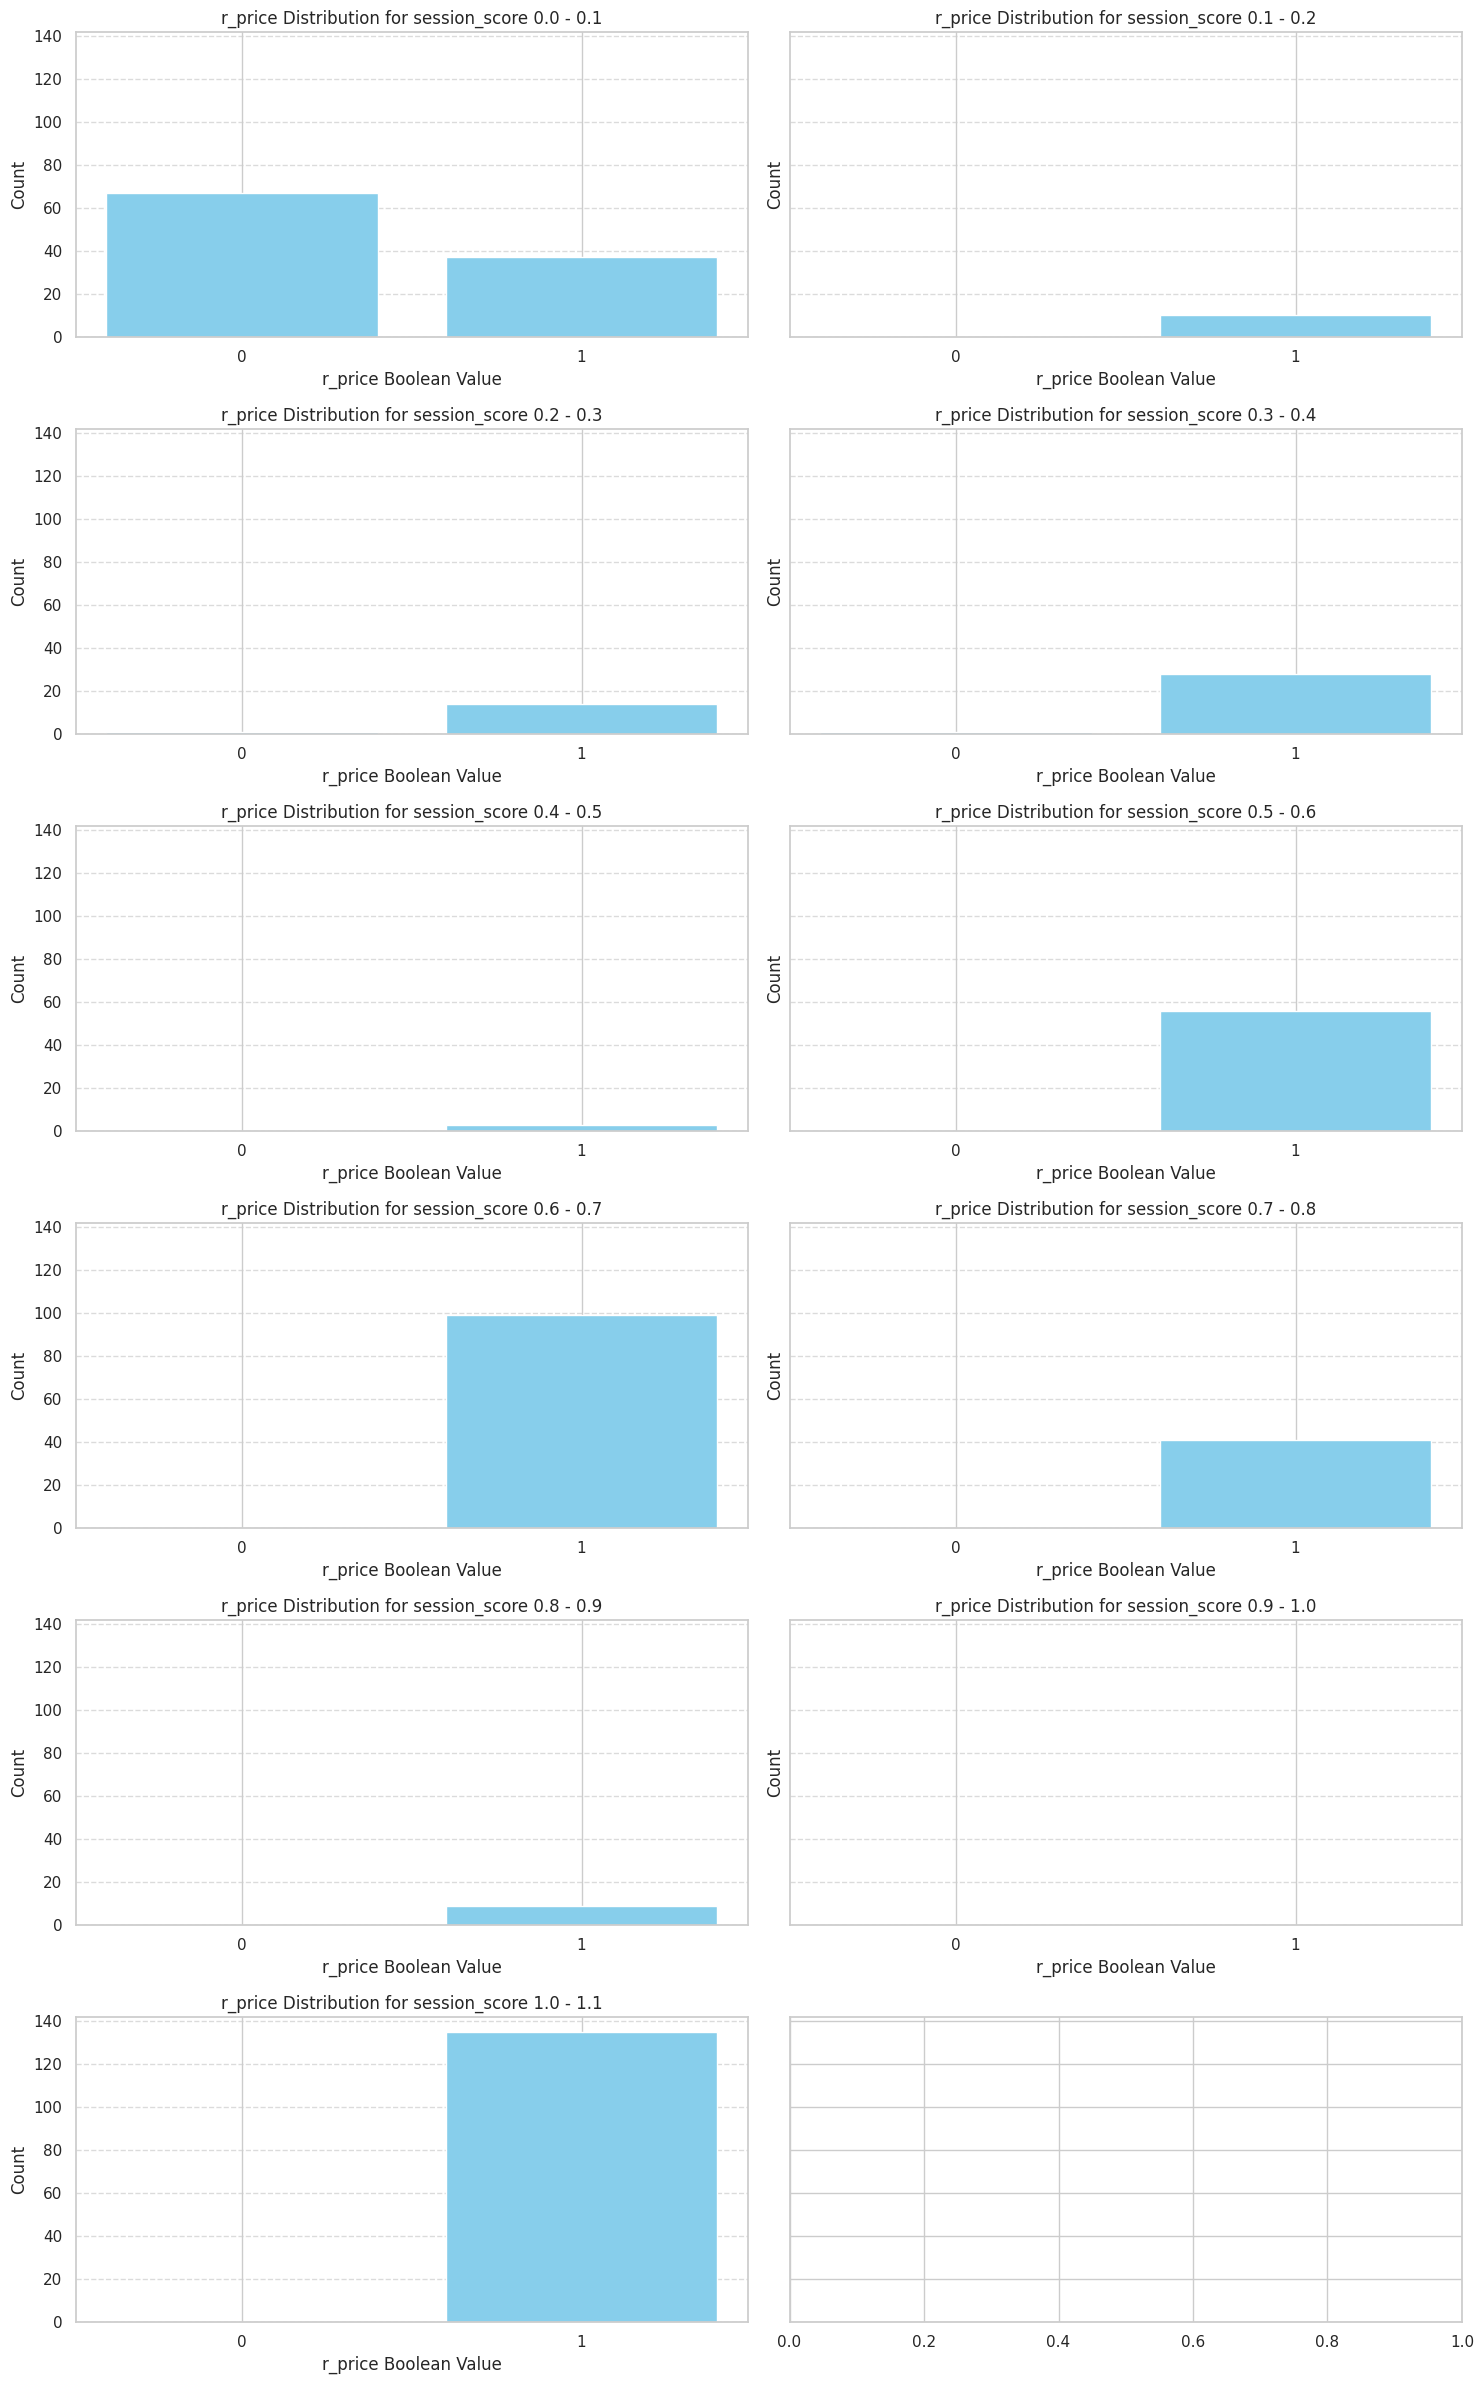

In [132]:
def plot_r_price_distribution_per_score_bucket(sessions):
    # Define the score buckets (referencing the previous cell)
    score_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Initialize a dictionary to hold counts for each score bucket and r_price boolean values
    score_bucket_r_price_counts = {f"{lower:.1f} - {upper:.1f}": {'0': 0, '1': 0} for lower, upper in score_buckets}

    for session in sessions:
        session_score = session['session_score']
        r_price = session['r_price']

        # Determine the score bucket
        score_bucket = None
        for lower, upper in score_buckets:
            if lower <= session_score < upper:
                score_bucket = f"{lower:.1f} - {upper:.1f}"
                break

        # Determine the r_price boolean value
        r_price_bucket = '1' if r_price > 0 else '0'

        # Increment the count for the corresponding bucket
        if score_bucket:
            score_bucket_r_price_counts[score_bucket][r_price_bucket] += 1

    # Plotting
    fig, axes = plt.subplots(6, 2, figsize=(15, 24), sharey=True)
    axes = axes.flatten()

    for idx, (score_bucket, r_price_counts) in enumerate(score_bucket_r_price_counts.items()):
        if idx >= len(axes):
            break  # Prevent IndexError if there are more buckets than subplots

        bucket_ranges = list(r_price_counts.keys())
        counts = list(r_price_counts.values())

        axes[idx].bar(bucket_ranges, counts, color='skyblue')
        axes[idx].set_xlabel('r_price Boolean Value')
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'r_price Distribution for session_score {score_bucket}')
        axes[idx].tick_params(axis='x', rotation=0)
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_r_price_distribution_per_score_bucket(sessions)


## query_match bucketing wrt session score bucketing

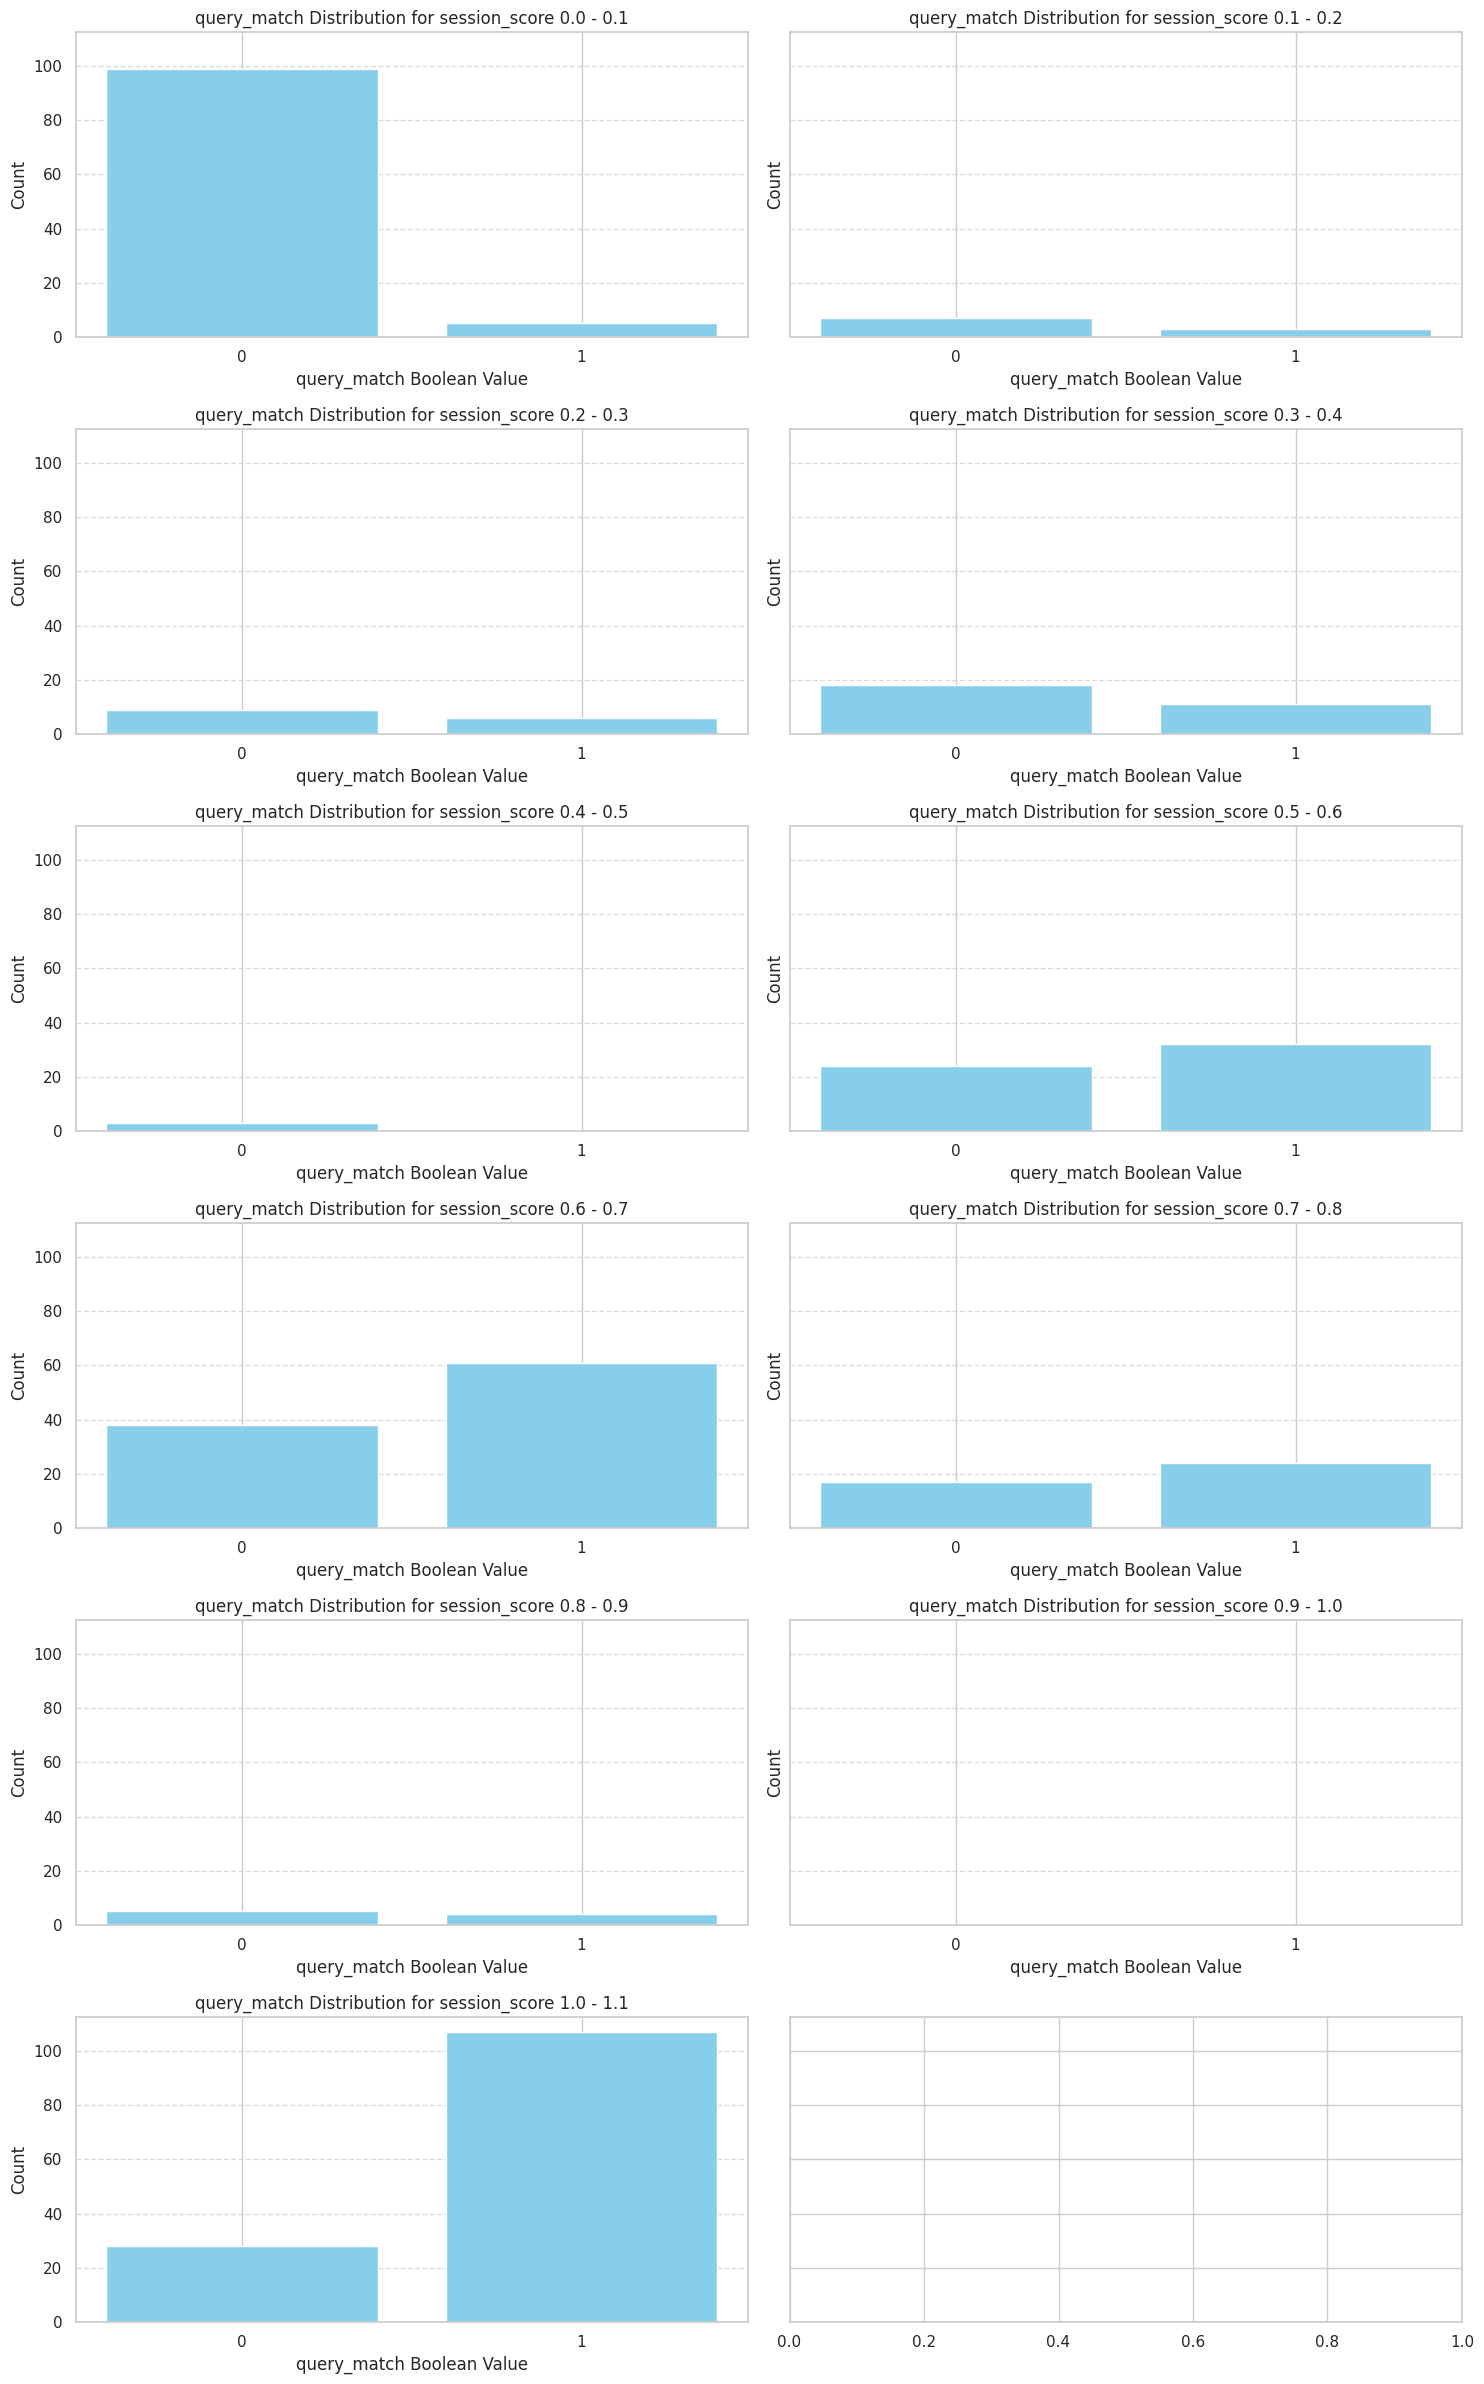

In [133]:
def plot_query_match_distribution_per_score_bucket(sessions):
    # Define the score buckets (referencing the previous cell)
    score_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Initialize a dictionary to hold counts for each score bucket and query_match boolean values
    score_bucket_query_match_counts = {f"{lower:.1f} - {upper:.1f}": {'0': 0, '1': 0} for lower, upper in score_buckets}

    for session in sessions:
        session_score = session['session_score']
        query_match = session['query_match']

        # Determine the score bucket
        score_bucket = None
        for lower, upper in score_buckets:
            if lower <= session_score < upper:
                score_bucket = f"{lower:.1f} - {upper:.1f}"
                break

        # Determine the query_match boolean value
        query_match_bucket = '1' if query_match > 0 else '0'

        # Increment the count for the corresponding bucket
        if score_bucket:
            score_bucket_query_match_counts[score_bucket][query_match_bucket] += 1

    # Plotting
    fig, axes = plt.subplots(6, 2, figsize=(15, 24), sharey=True)
    axes = axes.flatten()

    for idx, (score_bucket, query_match_counts) in enumerate(score_bucket_query_match_counts.items()):
        if idx >= len(axes):
            break  # Prevent IndexError if there are more buckets than subplots

        bucket_ranges = list(query_match_counts.keys())
        counts = list(query_match_counts.values())

        axes[idx].bar(bucket_ranges, counts, color='skyblue')
        axes[idx].set_xlabel('query_match Boolean Value')
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'query_match Distribution for session_score {score_bucket}')
        axes[idx].tick_params(axis='x', rotation=0)
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_query_match_distribution_per_score_bucket(sessions)


## category_match bucketing wrt session score bucketing

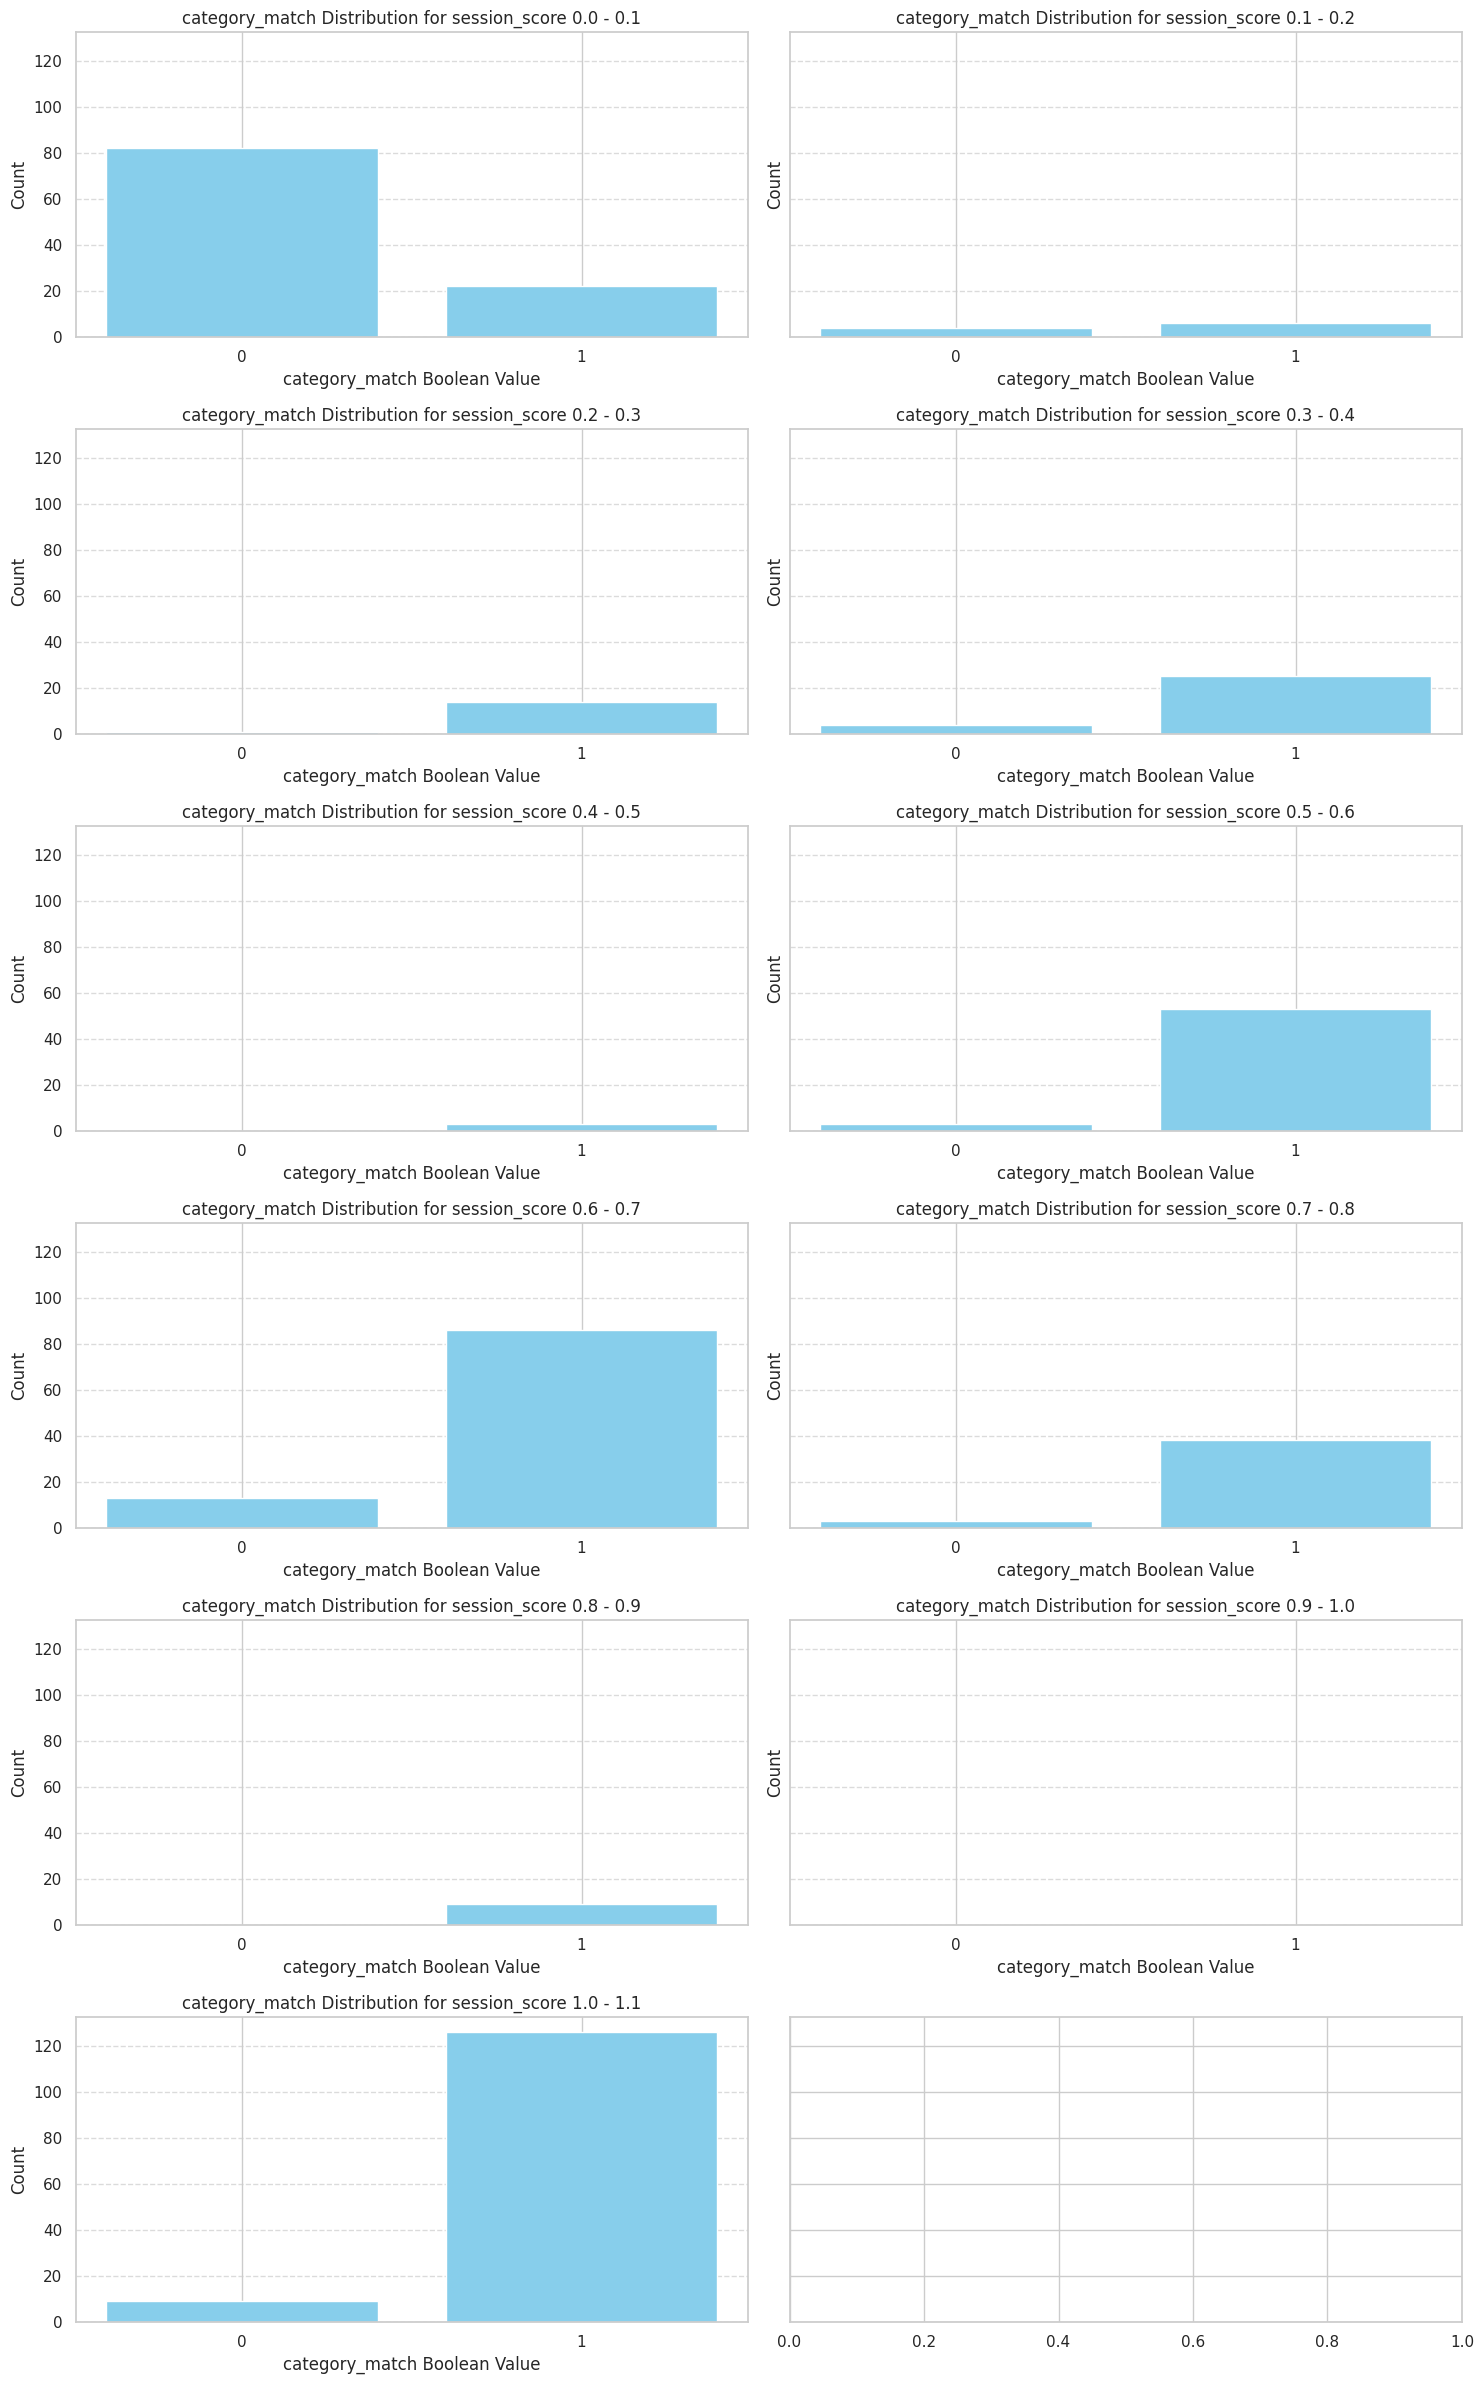

In [134]:
def plot_category_match_distribution_per_score_bucket(sessions):
    # Define the score buckets (referencing the previous cell)
    score_buckets = [(i / 10, (i + 1) / 10) for i in range(0, 11)]
    
    # Initialize a dictionary to hold counts for each score bucket and category_match boolean values
    score_bucket_category_match_counts = {f"{lower:.1f} - {upper:.1f}": {'0': 0, '1': 0} for lower, upper in score_buckets}

    for session in sessions:
        session_score = session['session_score']
        category_match = session['category_match']

        # Determine the score bucket
        score_bucket = None
        for lower, upper in score_buckets:
            if lower <= session_score < upper:
                score_bucket = f"{lower:.1f} - {upper:.1f}"
                break

        # Determine the category_match boolean value
        category_match_bucket = '1' if category_match > 0 else '0'

        # Increment the count for the corresponding bucket
        if score_bucket:
            score_bucket_category_match_counts[score_bucket][category_match_bucket] += 1

    # Plotting
    fig, axes = plt.subplots(6, 2, figsize=(15, 24), sharey=True)
    axes = axes.flatten()

    for idx, (score_bucket, category_match_counts) in enumerate(score_bucket_category_match_counts.items()):
        if idx >= len(axes):
            break  # Prevent IndexError if there are more buckets than subplots

        bucket_ranges = list(category_match_counts.keys())
        counts = list(category_match_counts.values())

        axes[idx].bar(bucket_ranges, counts, color='skyblue')
        axes[idx].set_xlabel('category_match Boolean Value')
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'category_match Distribution for session_score {score_bucket}')
        axes[idx].tick_params(axis='x', rotation=0)
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_category_match_distribution_per_score_bucket(sessions)
